<a href="https://colab.research.google.com/github/RajuMopidevi/Automatic-Ticket-Classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfTransformer

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://drive.google.com/u/0/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K&export=download", "complaints-2021-05-14_08_16.json")



('complaints-2021-05-14_08_16.json',
 <http.client.HTTPMessage at 0x7fe9b6274490>)

In [3]:
ls -ltr 

total 81444
drwxr-xr-x 1 root root     4096 Jan  9 14:36 sample_data/
-rw-r--r-- 1 root root 83392514 Jan 18 10:16 complaints-2021-05-14_08_16.json


In [4]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
#shape
df.shape

(78313, 22)

In [6]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [10]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [11]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    text = text.lower() # to lower case
    text = text.strip() # trim operation
    text = re.sub(r"[\[].*?[\]]","",text).strip() #remove within square bracket
    text = re.sub(r"[^\w\s]","",text).strip() # remove punctuation
    text = re.sub("\S*\d\S*","",text).strip() # remove words containing numbers
    return text

In [13]:
#Cleaning column 'complaint_what_happened'
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [14]:
# Import the necessary libraries for cleanup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [16]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
  
  # Creating a list to store the lemmatized words
  lemma_list = []

  # Extrating the lemmas from the given text
  doc = nlp(text)
  for token in doc:
    lemma_list.append(token.lemma_)

  # Converting the string into list
  string = " ".join(lemma_list)

  return string

In [17]:
df['lemmatized_complaint'] = df['complaint_what_happened'].apply(lambda x: lemmatize_text(x))
# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in and be tell b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent a...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided,on while try to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it i...


In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [19]:
df_clean

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...


In [20]:
#Write your function to extract the POS tags 
def pos_tag(text):
    NN_POS_list=[]
    tokens = nltk.word_tokenize(text)
    tag = nltk.pos_tag(tokens)
    for (word,tag) in tag:
        if tag=='NN':
            NN_POS_list.append(word)
    return " ".join(NN_POS_list)


##this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)

#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

# View the dataframe
df_clean.head()



<ipython-input-20-7c84070d2d3a>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


In [21]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [22]:
#length of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

[159, 105, 74, 414, 161, 7, 629, 585, 1186, 51]

Text(0.5, 0, 'Complaint Character length ranges')

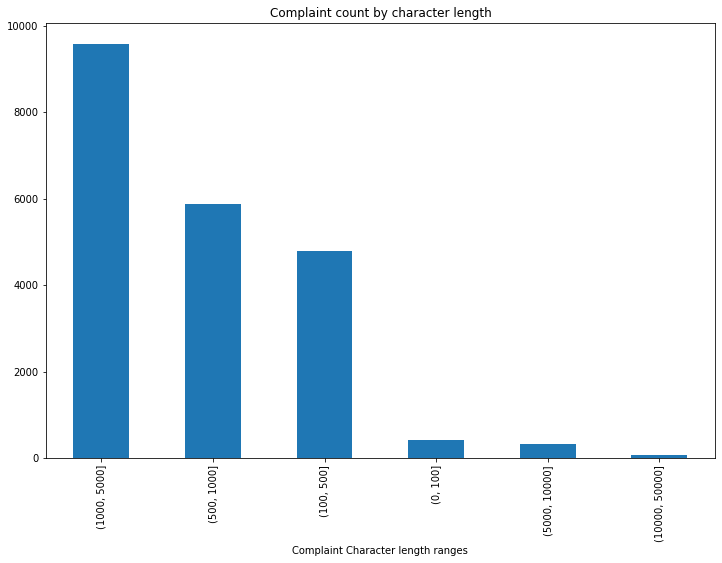

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean['complaint_what_happened'].str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Complaint Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

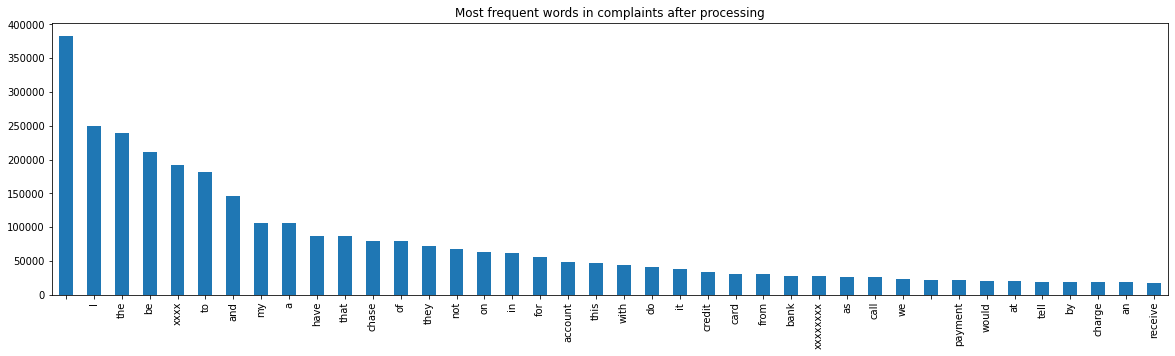

In [24]:
# Most frequent words in the processed (lemmatized) complaints
most_freq_lem=[]
for complaint in df_clean['lemmatized_complaint']:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

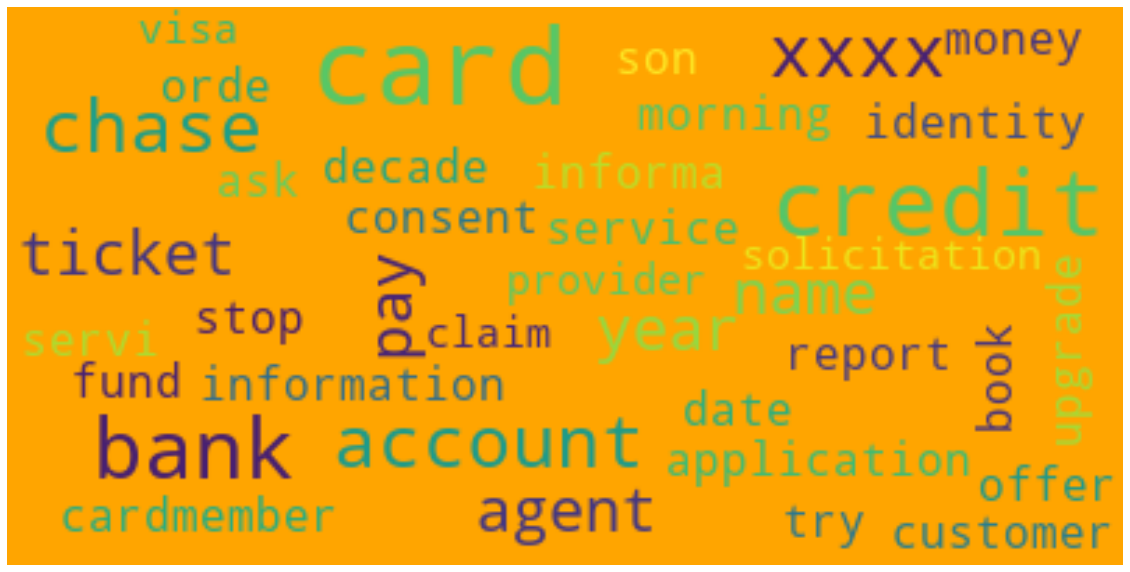

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='orange',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

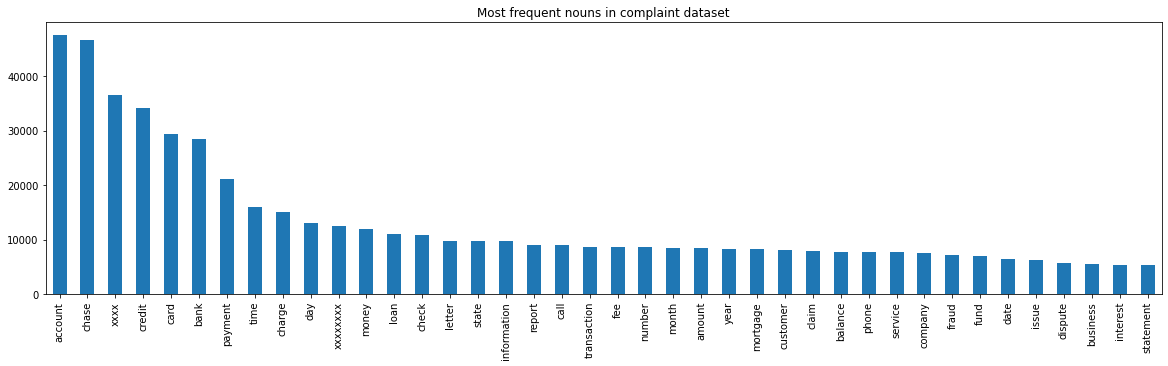

In [26]:
# Most frequent nouns in the processed complaints
most_freq_nouns=[] 
for complaint in df_clean['complaint_POS_removed']:
    for word in complaint.split(' '):
        most_freq_nouns.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent nouns in complaint dataset")
plt.show()

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-27-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom xxxx probl...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [30]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,account,47492
1,chase,46692
2,xxxx,36530
3,credit,34132
4,card,29279
5,bank,28407
6,payment,21166
7,time,16033
8,charge,14992
9,day,12966


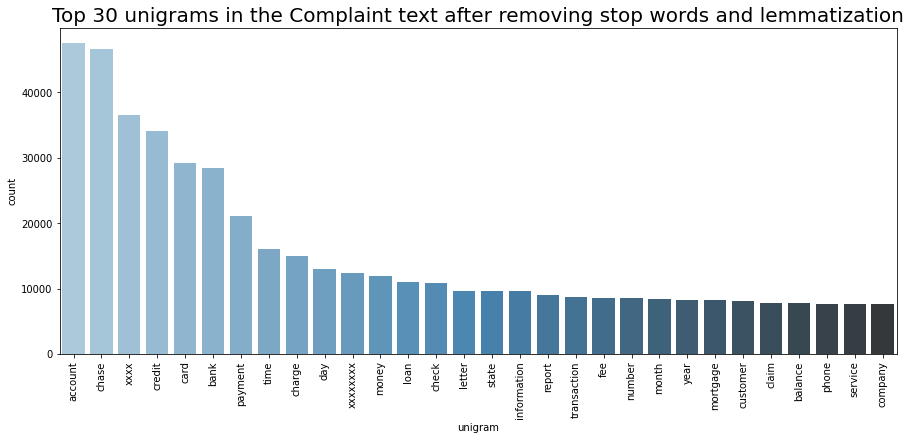

In [31]:
# Top 30 words by their frequency
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [33]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12779
1,credit report,4003
2,xxxx xxxx,3931
3,customer service,3079
4,chase credit,2967
5,chase bank,2942
6,bank account,2778
7,chase account,2619
8,account chase,2595
9,account account,2414


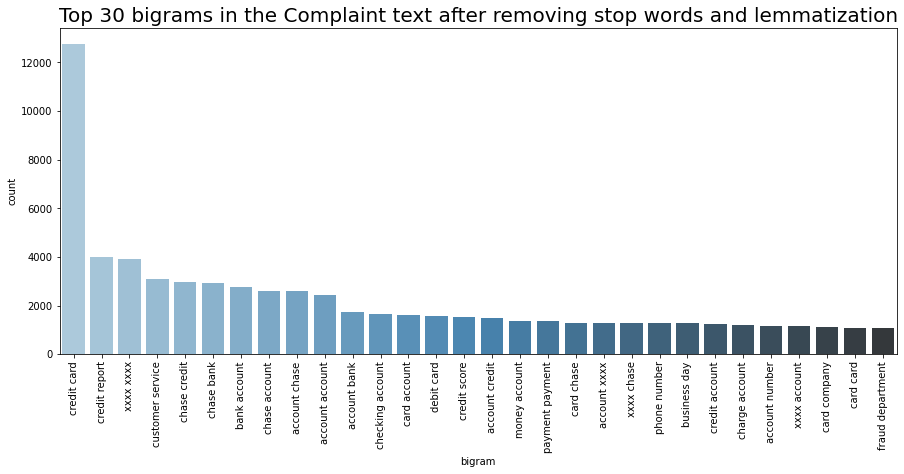

In [34]:
# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [35]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [36]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,634
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,401
9,card credit card,388


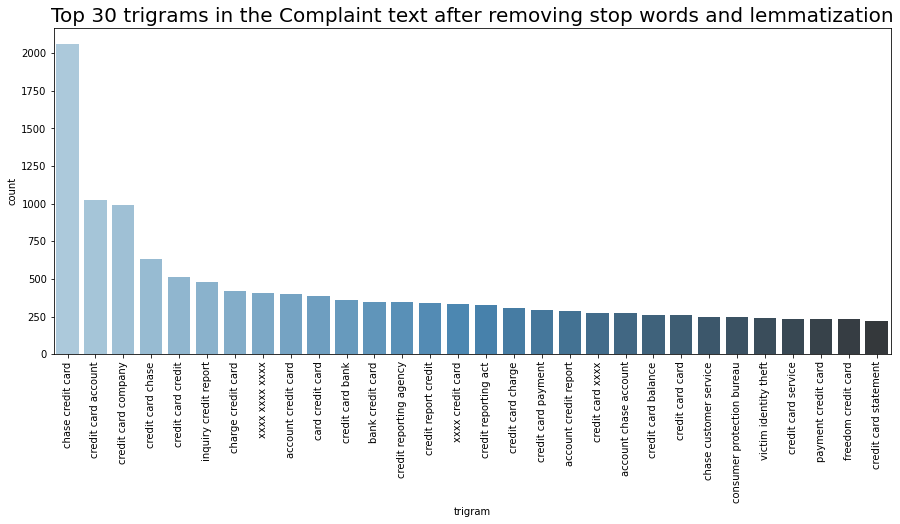

In [37]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [38]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

<ipython-input-38-407a11c00e2d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-38-407a11c00e2d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,try book ticket offer ticket card information...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom problem b...,credit yr credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [40]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [41]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
features = tfidf_vectorizer.get_feature_names_out()

# Creating a dataframe to display the document-term matrix created above
dtm = pd.DataFrame(tfidf.toarray(), columns = features)
dtm.head()

,ability,abuse,accept,acceptance,access,access account,access bank,access card,access chase,access credit,...,year payment,year problem,year rate,year time,year year,yesterday,york,yr,zero,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here
len(tfidf_vectorizer.get_feature_names_out())

5000

In [44]:
nmf_model.fit(dtm)
len(tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



5000

In [45]:
W = nmf_model.fit_transform(dtm)  # Document-Topic matrix
H = nmf_model.components_ 

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [46]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,fund,deposit,transaction,day,branch,claim,bank account,number,account account,fraud
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,company,service,merchant,fraud,balance,time
Topic 3,loan,mortgage,home,chase,modification,property,year,letter,document,time,rate,foreclosure,sale,house,loan modification
Topic 4,credit,report,credit report,inquiry,inquiry credit,inquiry credit report,account,debt,report credit,score,information,reporting,identity,credit score,account credit
Topic 5,payment,payment payment,balance,fee,month,statement,payment account,time,account payment,payment chase,day,auto,payment month,payment credit,chase payment


In [47]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}


In [48]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()) if x.idxmax() in topic_mapping.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.019238,0.003746,0.015087,0.013592,0.004602,0
1,0.008143,0.016699,0.005794,0.001906,0.001555,1
2,0.000000,0.019652,0.000000,0.045866,0.000000,3
3,0.016094,0.021852,0.016205,0.067242,0.000000,3
4,0.055271,0.000000,0.003140,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.103276,0.000000,3
6,0.056852,0.004101,0.004924,0.000000,0.011229,0
7,0.003283,0.007389,0.043163,0.000000,0.056382,4
8,0.036445,0.021941,0.019229,0.001820,0.002754,0
9,0.000000,0.048654,0.000000,0.071352,0.000000,3


In [49]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic'].apply(lambda x:int(x)) #write your code to assign topics to each rows.

<ipython-input-49-571781b8a800>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,3
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,try book ticket offer ticket card information...,3
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [51]:
df_clean.Topic.value_counts()

1    6368
0    6080
2    3672
3    2505
4    2447
Name: Topic, dtype: int64

In [52]:
df_clean.shape


(21072, 5)

In [53]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
9658,i am filing a complaint to ask chase bank to e...,I be file a complaint to ask chase bank to ext...,complaint bank time checking account account f...,complaint bank time checking account account f...,0
9659,i opened up an account with chase bank and i w...,I open up an account with chase bank and I be ...,account bank fee account fee fraud account occ...,account bank fee account fee fraud account occ...,0
9660,i filed against chase bank refused refund for...,I file against chase bank refuse refund for ...,chase bank refuse refund banking service accou...,chase bank refuse refund banking service accou...,0
9661,xxxx fraudulent checks were posted to my check...,xxxx fraudulent check be post to my checking a...,check account signature signature line upon a...,check account signature signature line upon a...,0
...,...,...,...,...,...
19313,i called chase auto finance on xxxx xxxx to g...,I call chase auto finance on xxxx xxxx to ge...,auto finance payoff amount process purchase en...,auto finance payoff amount process purchase en...,4
12041,on my bill did not go through when it was on ...,on my bill do not go through when it be on a...,bill autobill company payment try bank rejecti...,bill autobill company payment try bank rejecti...,4
7061,i opened a charge account through slate chase ...,I open a charge account through slate chase ba...,charge account slate chase bank year year paym...,charge account slate chase bank year year paym...,4
12173,i have been a loyal chase customer with not on...,I have be a loyal chase customer with not only...,chase customer credit card payment time assist...,chase customer credit card payment time assist...,4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [54]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-54-0bc1fb6bab53>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit Card/Prepaid Card
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Theft/Dispute reporting
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,try book ticket offer ticket card information...,Theft/Dispute reporting
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit Card/Prepaid Card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Credit Card/Prepaid Card
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute reporting
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom problem b...,credit yr credit card chase freedom problem b...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [56]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-56-135395e126bd>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,3
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,try book ticket offer ticket card information...,3
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,1
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom problem b...,credit yr credit card chase freedom problem b...,4


In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint_what_happened", "Topic"]]

In [59]:
training_data

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,3
3,on while trying to book a xxxx xxxx ticket ...,3
4,my grand son give me check for i deposit it i...,0
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,1
21069,i am not familiar with xxxx pay and did not un...,3
21070,i have had flawless credit for yrs ive had ch...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaint_what_happened  21072 non-null  object
 1   Topic                    21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [61]:

#Write your code to get the Vector count
count_vector = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = count_vector.fit_transform(training_data['complaint_what_happened'])
print(vector.toarray())

#Write your code here to transform the word vector to tf-idf
tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
print("\nTransformed Word vector to Tf-idf : {}".format(word_vect.shape))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 3 1 0]]

Transformed Word vector to Tf-idf : (21072, 820)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [68]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn import metrics

def accuracy_evaluation(y_actual,y_pred,model_name):
    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(metrics.classification_report(y_actual, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
       
    # Confusion matrix
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    
    #Heatmap with confusion matrix data
    sns.heatmap(confusion, annot=True, cbar=None, cmap="coolwarm", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    
    print("Accuracy   : " + str(accuracy)) 
    return accuracy

In [63]:
train_df = pd.DataFrame(word_vect.toarray(),columns=count_vector.get_feature_names(),index=training_data.index)
train_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,ability,able,absolutely,accept,accepted,access,according,account,account called,account chase,...,xxxxxxxx chase,xxxxxxxx received,xxxxxxxx xxxx,xxxxxxxx xxxx xxxx,xxxxxxxx xxxxxxxx,xxxxxxxxxxxx,year,years,years ago,yes
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062761,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.077125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.184686,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.111602,0.0,0.0,0.0,0.0,0.107662,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125582,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [64]:
train_df["Topic"] = training_data["Topic"]

In [65]:
train_df.head()

,ability,able,absolutely,accept,accepted,access,according,account,account called,account chase,...,xxxxxxxx received,xxxxxxxx xxxx,xxxxxxxx xxxx xxxx,xxxxxxxx xxxxxxxx,xxxxxxxxxxxx,year,years,years ago,yes,Topic
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062761,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.077125,0.0,0.0,...,0.0,0.0,0.0,0.184686,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.111602,0.0,0.0,0.0,0.0,0.107662,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125582,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [66]:
from sklearn.model_selection import train_test_split

X= train_df.drop(['Topic'], axis=1)
y= train_df['Topic']

# Splitting the data into train and test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=40, stratify=y)

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

### Model -1 : Logistic Regression

Training data accuracy

CLASSIFICATION REPORT for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.96      0.98      0.97      4256
Credit card or prepaid card       0.96      0.98      0.97      4458
                     Others       0.97      0.96      0.96      2570
    Theft/Dispute Reporting       0.97      0.94      0.96      1753
              Mortgage/Loan       0.98      0.93      0.95      1713

                   accuracy                           0.97     14750
                  macro avg       0.97      0.96      0.96     14750
               weighted avg       0.97      0.97      0.96     14750



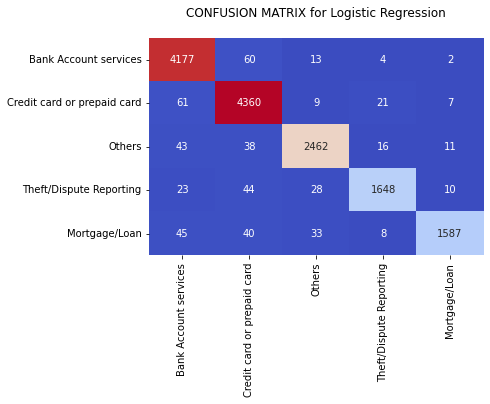

Accuracy   : 0.9650169491525423


In [69]:

logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_regression.fit(xtrain, ytrain)

ytrain_pred = logistic_regression.predict(xtrain)
ytest_pred = logistic_regression.predict(xtest)

print("Training data accuracy\n")
training_accuracy = accuracy_evaluation(ytrain.values,ytrain_pred,'Logistic Regression')

Test data accuracy

CLASSIFICATION REPORT for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.93      0.96      0.94      1824
Credit card or prepaid card       0.94      0.96      0.95      1910
                     Others       0.94      0.93      0.94      1102
    Theft/Dispute Reporting       0.95      0.89      0.92       752
              Mortgage/Loan       0.95      0.90      0.92       734

                   accuracy                           0.94      6322
                  macro avg       0.94      0.93      0.93      6322
               weighted avg       0.94      0.94      0.94      6322



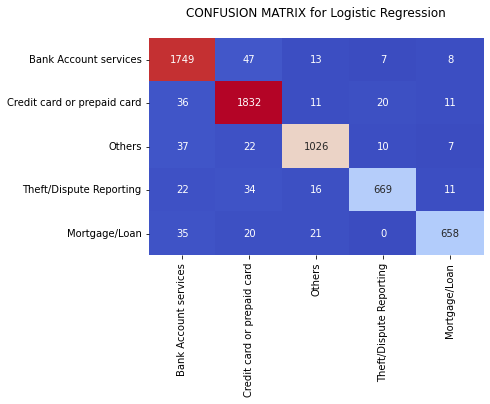

Accuracy   : 0.9386270167668459


In [70]:
print("Test data accuracy\n")
test_accuracy = accuracy_evaluation(ytest.values,ytest_pred,'Logistic Regression')

### Model - 2 : Decision Tree Classifier

Train Accuracy
CLASSIFICATION REPORT for Decision Tree Classifier

                             precision    recall  f1-score   support

      Bank Account services       0.87      0.81      0.84      4256
Credit card or prepaid card       0.88      0.82      0.85      4458
                     Others       0.75      0.84      0.79      2570
    Theft/Dispute Reporting       0.80      0.85      0.83      1753
              Mortgage/Loan       0.83      0.89      0.86      1713

                   accuracy                           0.84     14750
                  macro avg       0.83      0.84      0.83     14750
               weighted avg       0.84      0.84      0.84     14750



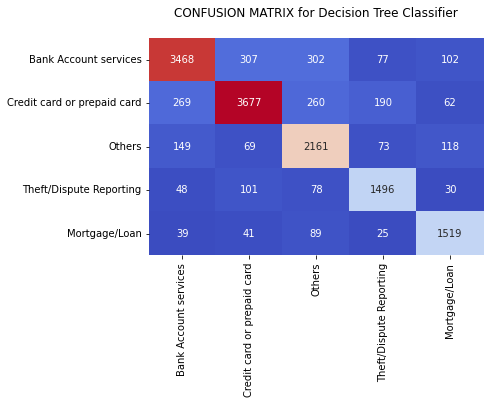

Accuracy   : 0.8353220338983051


In [71]:

# Checking initial tree with standard params
dt = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
dt.fit(xtrain,ytrain)

# predict the train and test
ytrain_pred_dt  = dt.predict(xtrain)
ytest_pred_dt = dt.predict(xtest)

# check for model accuracy
print("Train Accuracy")
train_accuracy = accuracy_evaluation(ytrain.values, ytrain_pred_dt,"Decision Tree Classifier")

Test Accuracy
CLASSIFICATION REPORT for Decision Tree Classifier

                             precision    recall  f1-score   support

      Bank Account services       0.84      0.78      0.81      1824
Credit card or prepaid card       0.82      0.78      0.80      1910
                     Others       0.71      0.82      0.76      1102
    Theft/Dispute Reporting       0.75      0.77      0.76       752
              Mortgage/Loan       0.79      0.81      0.80       734

                   accuracy                           0.79      6322
                  macro avg       0.78      0.79      0.79      6322
               weighted avg       0.79      0.79      0.79      6322



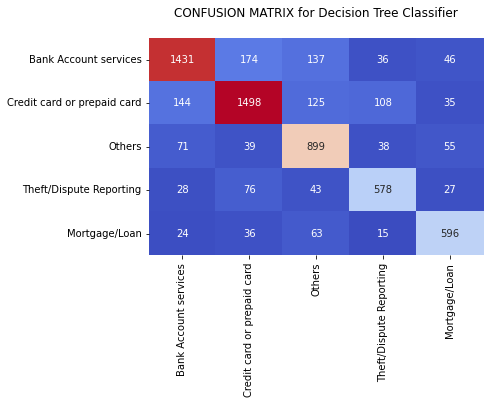

Accuracy   : 0.7912053147738057


In [72]:
# test data accuracy
print("Test Accuracy")
test_accuracy_dt = accuracy_evaluation(ytest.values,ytest_pred_dt,"Decision Tree Classifier")

In [75]:
dt = DecisionTreeClassifier(random_state = 40, class_weight="balanced")

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["entropy", "gini"]
}

grid_search = GridSearchCV(estimator = dt,param_grid = params,cv = 5, n_jobs=-1, verbose=1, scoring="accuracy", return_train_score=True)

grid_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=40),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 50]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [76]:
# Get the results in tabular format
scores = grid_search.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.674199,0.086773,0.020267,0.003151,entropy,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.713220,0.692881,...,0.705966,0.006899,29,0.717458,0.715678,0.720593,0.713220,0.716695,0.716729,0.002403
1,2.599483,0.026201,0.019792,0.001323,entropy,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.713559,0.692881,...,0.705966,0.006975,29,0.717203,0.715678,0.720339,0.713390,0.716356,0.716593,0.002261
2,2.511059,0.034268,0.019187,0.000820,entropy,5,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.712881,0.693559,...,0.705695,0.006487,31,0.717034,0.714746,0.720000,0.713814,0.716356,0.716390,0.002135
3,2.385365,0.021306,0.019255,0.000843,entropy,5,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.714237,0.690169,...,0.704203,0.007803,32,0.716780,0.712203,0.717458,0.714407,0.712881,0.714746,0.002076
4,4.167152,0.068309,0.021037,0.003820,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.787458,0.799661,...,0.791864,0.005705,14,0.849915,0.851949,0.845593,0.848220,0.856525,0.850441,0.003688


### Model - 3 : Naive Bayes

In [77]:

model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(xtrain, ytrain)
y_pred_nb = nb.predict(xtest)

In [78]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(xtrain, ytrain)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 1, 'fit_prior': False}


In [79]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=1,fit_prior=False)
nb_tuned.fit(xtrain, ytrain)
ypred_train_nb_tuned = nb_tuned.predict(xtrain)
ypred_test_nb_tuned = nb_tuned.predict(xtest)

In [80]:
# Calculate F1 Score of model using weighted average method
f1_nb = metrics.f1_score(ytrain.values, ypred_train_nb_tuned, average="weighted")
print("Training f1_score : {}".format(f1_nb))

# Calculate F1 Score of model using weighted average method
f1_nb = metrics.f1_score(ytest.values, ypred_test_nb_tuned, average="weighted")
print("Test f1_score : {}".format(f1_nb))

Training f1_score : 0.8521864767232356
Test f1_score : 0.8437488593098224


Training Accuracy

CLASSIFICATION REPORT for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.89      0.89      0.89      4256
Credit card or prepaid card       0.91      0.82      0.87      4458
                     Others       0.85      0.88      0.86      2570
    Theft/Dispute Reporting       0.77      0.88      0.82      1753
              Mortgage/Loan       0.71      0.77      0.74      1713

                   accuracy                           0.85     14750
                  macro avg       0.83      0.85      0.84     14750
               weighted avg       0.86      0.85      0.85     14750



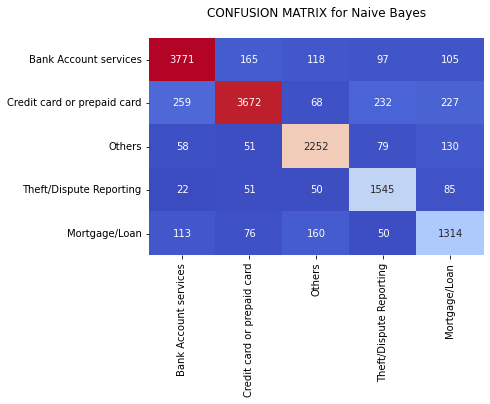

Accuracy   : 0.8511186440677966


In [81]:
# Evaluate the Naive Bayes classifier
print("Training Accuracy\n")
Training_acc = accuracy_evaluation(ytrain.values, ypred_train_nb_tuned, "Naive Bayes")

Test Accuracy

CLASSIFICATION REPORT for Naive Bayes

                             precision    recall  f1-score   support

      Bank Account services       0.89      0.88      0.88      1824
Credit card or prepaid card       0.91      0.81      0.86      1910
                     Others       0.84      0.87      0.86      1102
    Theft/Dispute Reporting       0.75      0.87      0.81       752
              Mortgage/Loan       0.69      0.77      0.73       734

                   accuracy                           0.84      6322
                  macro avg       0.82      0.84      0.83      6322
               weighted avg       0.85      0.84      0.84      6322



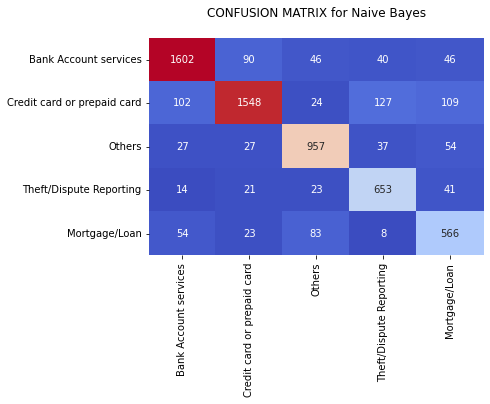

Accuracy   : 0.8424549193293261


In [82]:
# Evaluate the Naive Bayes classifier
print("Test Accuracy\n")
Test_acc = accuracy_evaluation(ytest.values, ypred_test_nb_tuned, "Naive Bayes")

**Observation**: Logistic Regression gives best results with an accuracy of  **0.9386**

### Model Inference

In [85]:
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [86]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [87]:
# Save the best model which is logistic regression model
pickle.dump(logistic_regression, open("logistic_reg_model.pkl", "wb"))

In [88]:
def Predict_Topic(text):
    
    target_names = ["Bank Account services", "Credit card / Prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logistic_reg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [100]:
sample_complaints=["How do I close my account in your bank","How to apply new ICICI credit card ? ","My transaction shows failed but money got debited from my account"]


In [101]:
for complaint in sample_complaints:
    print("Complaint: "+complaint + " -----> " +Predict_Topic([complaint]), end='\n')
   

Complaint: How do I close my account in your bank -----> Bank Account services
Complaint: How to apply new ICICI credit card ?  -----> Credit card / Prepaid card
Complaint: My transaction shows failed but money got debited from my account -----> Bank Account services
